## improved GAN 简介
* improved GAN 也叫WGAN-GP，采用了gradient penalty 的方法，使WGAN网络更容易训练
* wGAN 中采用 weight clipping 的方法，就是将训练的参数绝对值做weight clipping， 让其不超过一个常数a。但是存在两个问题：
*  1、训练出来的权值分布不理想，权值集中在个人所限制的最大值和最小值两个极端上
*  2、易导致梯度消失或者梯度爆炸
* 在 improved_GAN 中采用了gradient penalty（梯度惩罚）的方法，有效地避免了这两个问题

实验表明，gradient penalty能够显著提高训练速度，解决了原始WGAN收敛缓慢的问题

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
from glob import glob
import os

import helper

In [2]:
mnist = input_data.read_data_sets('./MNIST_data', one_hot=True)

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

In [3]:
mnist_datadir = './mnist'
celeba_datadir = './img_align_celeba'

(4, 4, 28, 28)
(16, 28, 28)


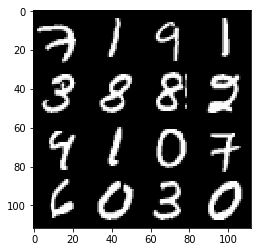

In [4]:
show_n_images = 16

mnist_images = np.reshape(mnist.train.images[:show_n_images], (show_n_images,28, 28))
plt.imshow(helper.my_images_square_grid(mnist_images, 'L'), cmap='gray')
print(mnist_images.shape)

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。

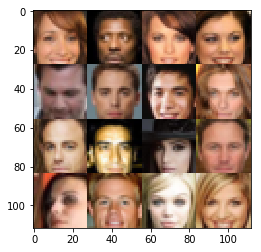

In [5]:
mnist_images = helper.get_batch(glob(os.path.join(celeba_datadir, '*.jpg'))[:show_n_images], 28, 28, 'RGB')
plt.imshow(helper.images_square_grid(mnist_images, 'RGB'))

### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)]
创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0.

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。

In [6]:
def model_inputs(image_width, image_height, image_channels, z_dim):

    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None))
    
    return inputs_real, inputs_z, learning_rate


### 定义 LeakRelu

In [7]:
def LeakRelu(alpha, x):
    x = tf.maximum(alpha * x, x)
    return x

### 辨别器（Discriminator）
* 判别器的模型架构中**不能使用Batch Normalization**，因为它会引入同个batch中不同样本的相互依赖关系。
* 如果需要的话，可以选择其他normalization方法，如Layer Normalization、Weight Normalization和Instance Normalization
#### 论文推荐的是Layer Normalization。

In [8]:
########### 没找到layer_nomalization 对应的接口，暂时先不用了。。 ##############

def discriminator(images, reuse = False):
    
    alpha = 0.2
    keep_prob = 0.8
    fc_weight_init = tf.contrib.layers.xavier_initializer()
    conv_weight_init = tf.contrib.layers.xavier_initializer_conv2d()
    
    with tf.variable_scope('discriminator', reuse = reuse):
        x1 = tf.layers.conv2d(images, 64, 3, strides = 2, padding='same', kernel_initializer = conv_weight_init)
        #x1 = tf.layers.batch_normalization(x1, training = True)
        x1 = LeakRelu(alpha, x1)
        #x1 = tf.nn.dropout(x1, keep_prob)
        
        x2 = tf.layers.conv2d(x1, 128, 3, strides=2, padding='same', kernel_initializer = conv_weight_init)
        #x2 = tf.layers.batch_normalization(x2, training = True)
        x2 = LeakRelu(alpha ,x2)
        #x2 = tf.nn.dropout(x2, keep_prob)
        
        x3 = tf.layers.conv2d(x2, 256, 3, strides = 2, padding = 'same', kernel_initializer = conv_weight_init)
        #x3 = tf.layers.batch_normalization(x3, training = True)
        x3 = LeakRelu(alpha, x3)
        #x3 = tf.nn.dropout(x3, keep_prob)
        
        x4 = tf.reshape(x3, (-1, int(x3.shape[1]) * int(x3.shape[2]) * int(x3.shape[3])))
        
        out = tf.layers.dense(x4, 1, kernel_initializer = fc_weight_init)
        ############## wgan 在此处取消了激活函数的使用 ##############
        
    return out


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [20]:
def generator(input_z, out_channel_dim, is_train = True):
    
    reuse  = not is_train
    alpha = 0.2
    keep_prob = 0.8
    fc_weight_init = tf.contrib.layers.xavier_initializer()
    conv_weight_init = tf.contrib.layers.xavier_initializer_conv2d()
    
    with tf.variable_scope('generator', reuse=reuse):

            x1 = tf.layers.dense(input_z, 4*4*512, kernel_initializer = conv_weight_init)
            x1 = tf.reshape(x1, (-1, 4, 4, 512))
            x1 = tf.layers.batch_normalization(x1, training=is_train)
            x1 = LeakRelu(alpha, x1)
            #x1 = tf.nn.dropout(x1, 0.8)
            # 4x4x512 

            x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid', kernel_initializer = conv_weight_init)
            x2 = tf.layers.batch_normalization(x2, training=is_train)
            x2 = LeakRelu(alpha, x2)
            #x2 = tf.nn.dropout(x2, 0.8)
            # 7x7x256 

            x3 = tf.layers.conv2d_transpose(x2, 128, 3, strides=2, padding='same', kernel_initializer = conv_weight_init)
            x3 = tf.layers.batch_normalization(x3, training=is_train)
            x3 = LeakRelu(alpha, x3)
            #x3 = tf.nn.dropout(x3, 0.8)
            # 14x14x128 now

            logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=2, padding='same', kernel_initializer =conv_weight_init)
            #x2 = tf.nn.dropout(x2, 0.8)
            # 28x28x3 now
            out = tf.tanh(logits)

    return out

### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。


In [18]:
def model_loss(input_real, input_z, image_channels, batch_size):
 
    real_out = discriminator(input_real, reuse = False)
    fake_images = generator(input_z, image_channels, is_train = True)
    fake_out = discriminator(fake_images, reuse = True) 

    d_real_loss = tf.reduce_mean(real_out)
    d_fake_loss = tf.reduce_mean(fake_out)
    d_loss = d_fake_loss - d_real_loss 
    # 计算梯度惩罚项
    alpha = tf.random_uniform(
        shape=[batch_size,1, 1, 1], 
        minval= 0.,
        maxval= 1.)
    differences = fake_images - input_real
    interpolates = input_real + (alpha*differences)
    gradients = tf.gradients(discriminator(interpolates, reuse = True), [interpolates])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
    gradient_penalty = tf.reduce_mean((slopes-1.)**2)
    d_loss += LAMBDA * gradient_penalty


    g_loss = -tf.reduce_mean(d_fake_loss)
    
    
    return d_loss, g_loss

### 优化（Optimization）
* wGAN 中采用 weight clipping 的方法，就是将训练的参数绝对值做weight clipping， 让其不超过一个常数a。但是存在两个问题：
*  1、权值分布不理想，集中在个人所限制的最大和最小两个极端上
*  2、易导致梯度消失或者梯度爆炸
* 在 improved_GAN 中采用了gradient penalty（梯度惩罚）的方法，有效地避免了这两个问题

In [11]:
def model_opt(d_loss, g_loss, learning_rate):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    all_var = tf.trainable_variables()
    g_var = [var for var in all_var if var.name.startswith('generator')]
    d_var = [var for var in all_var if var.name.startswith('discriminator')]
    
    all_train_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_update_ops = [ops for ops in all_train_ops if ops.name.startswith('generator')]
    d_update_ops = [ops for ops in all_train_ops if ops.name.startswith('discriminator')]
    

    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.RMSPropOptimizer(learning_rate).minimize(g_loss, var_list = g_var)
    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.RMSPropOptimizer(learning_rate).minimize(d_loss, var_list = d_var)

    return d_train_opt, g_train_opt

### 显示输出

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    plt.imshow(images_grid, cmap=cmap)
    plt.show()

### 训练

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # TODO: Build Model
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[-1], batch_size)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate)
    step = 0 
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step = step+1
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #print('batch_z shape=',batch_z.shape)
                # Run optimizers

                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, lr:learning_rate})
                
                if step % 200 == 0:
                    train_loss_d = d_loss.eval({inputs_z:batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z:batch_z})
                    print("Epoch {}/{} Step {}...".format(epoch_i+1, epoch_count, step),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))

                if step % 400 == 0:
                    show_generator_output(sess, 16, inputs_z, data_shape[3], data_image_mode)

### 训练 mnist 生成手写数字  

Epoch 1/1 Step 200... Discriminator Loss: 1.8247... Generator Loss: -41.0396
Epoch 1/1 Step 400... Discriminator Loss: 7.9670... Generator Loss: -33.8711


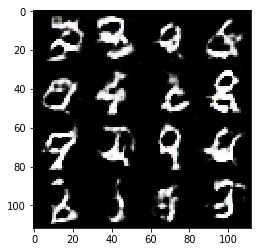

Epoch 1/1 Step 600... Discriminator Loss: 4.6706... Generator Loss: -26.9480
Epoch 1/1 Step 800... Discriminator Loss: -0.5996... Generator Loss: -69.3262


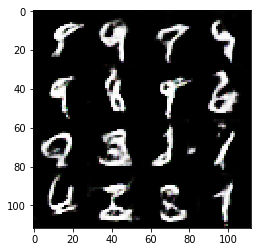

Epoch 1/1 Step 1000... Discriminator Loss: -1.0055... Generator Loss: -48.6198
Epoch 1/1 Step 1200... Discriminator Loss: 8.0381... Generator Loss: -79.0192


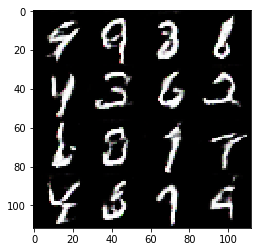

Epoch 1/1 Step 1400... Discriminator Loss: 2.3852... Generator Loss: -70.7124
Epoch 1/1 Step 1600... Discriminator Loss: 0.0100... Generator Loss: -83.9548


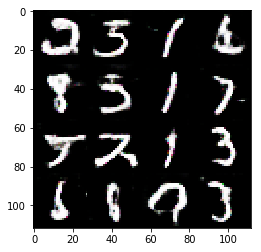

Epoch 1/1 Step 1800... Discriminator Loss: -6.5306... Generator Loss: -99.6454


In [21]:
batch_size =32
z_dim = 100
learning_rate = 0.003
LAMBDA = 12 # 梯度惩罚项lambda 
epochs = 1

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(mnist_datadir, '*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate,mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### 训练 celeba 生成人脸

Epoch 1/10 Step 200... Discriminator Loss: 12.4790... Generator Loss: -18.7272
Epoch 1/10 Step 400... Discriminator Loss: 1.6359... Generator Loss: -30.0416


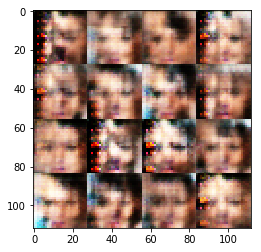

Epoch 1/10 Step 600... Discriminator Loss: 2.6095... Generator Loss: -18.5906
Epoch 1/10 Step 800... Discriminator Loss: 2.0571... Generator Loss: -13.3552


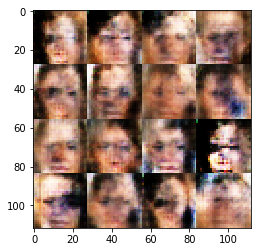

Epoch 1/10 Step 1000... Discriminator Loss: 2.8393... Generator Loss: -16.6180
Epoch 1/10 Step 1200... Discriminator Loss: 1.8049... Generator Loss: -19.3405


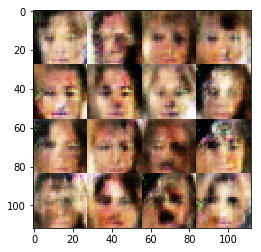

Epoch 1/10 Step 1400... Discriminator Loss: 2.0492... Generator Loss: -14.8087
Epoch 1/10 Step 1600... Discriminator Loss: 3.0216... Generator Loss: -11.5572


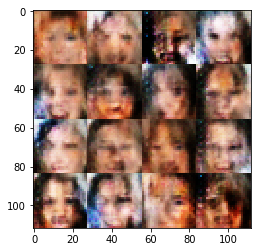

Epoch 1/10 Step 1800... Discriminator Loss: 0.1995... Generator Loss: 2.8175
Epoch 1/10 Step 2000... Discriminator Loss: 2.9795... Generator Loss: -9.8145


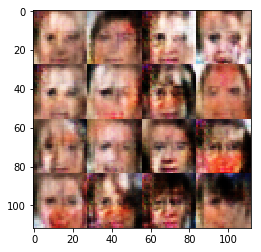

Epoch 1/10 Step 2200... Discriminator Loss: 1.2913... Generator Loss: -16.2170
Epoch 1/10 Step 2400... Discriminator Loss: 1.7042... Generator Loss: -16.0815


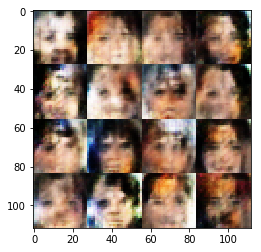

Epoch 1/10 Step 2600... Discriminator Loss: 2.0411... Generator Loss: -9.3851
Epoch 1/10 Step 2800... Discriminator Loss: 1.3377... Generator Loss: -3.1756


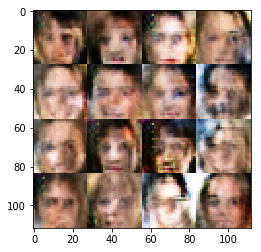

Epoch 1/10 Step 3000... Discriminator Loss: 2.0160... Generator Loss: -4.0691
Epoch 1/10 Step 3200... Discriminator Loss: 1.2073... Generator Loss: 4.4286


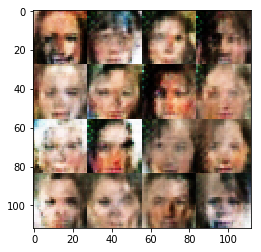

Epoch 1/10 Step 3400... Discriminator Loss: 1.1834... Generator Loss: 12.9922
Epoch 1/10 Step 3600... Discriminator Loss: 1.8046... Generator Loss: 0.9716


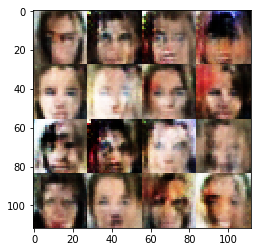

Epoch 1/10 Step 3800... Discriminator Loss: 1.0606... Generator Loss: 0.9815
Epoch 1/10 Step 4000... Discriminator Loss: 2.1982... Generator Loss: -3.2476


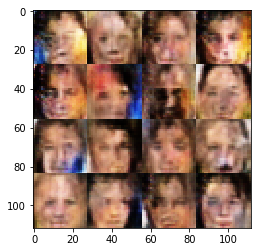

Epoch 1/10 Step 4200... Discriminator Loss: 3.6878... Generator Loss: 16.9467
Epoch 1/10 Step 4400... Discriminator Loss: 1.0294... Generator Loss: 5.1525


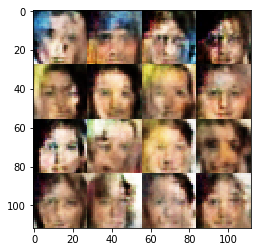

Epoch 1/10 Step 4600... Discriminator Loss: 1.3676... Generator Loss: -0.3718
Epoch 1/10 Step 4800... Discriminator Loss: 0.2369... Generator Loss: 2.7316


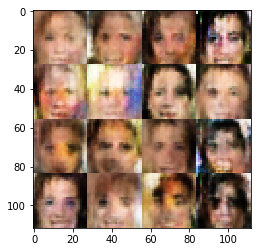

Epoch 1/10 Step 5000... Discriminator Loss: 1.7173... Generator Loss: 6.5570
Epoch 1/10 Step 5200... Discriminator Loss: 0.9299... Generator Loss: 13.5639


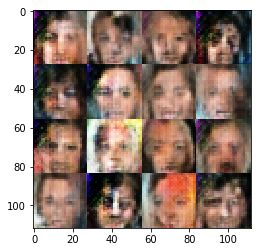

Epoch 1/10 Step 5400... Discriminator Loss: 0.7818... Generator Loss: -7.9239
Epoch 1/10 Step 5600... Discriminator Loss: 0.7118... Generator Loss: -6.0204


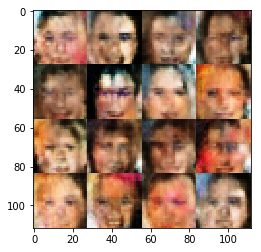

Epoch 1/10 Step 5800... Discriminator Loss: 1.1143... Generator Loss: 2.9005
Epoch 1/10 Step 6000... Discriminator Loss: 0.6755... Generator Loss: 7.9021


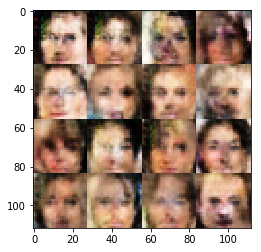

Epoch 1/10 Step 6200... Discriminator Loss: 2.1663... Generator Loss: -4.1962
Epoch 2/10 Step 6400... Discriminator Loss: 1.3690... Generator Loss: 0.9106


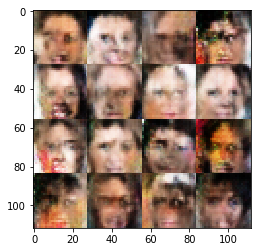

Epoch 2/10 Step 6600... Discriminator Loss: 0.4482... Generator Loss: -11.8755
Epoch 2/10 Step 6800... Discriminator Loss: 0.4127... Generator Loss: -19.0238


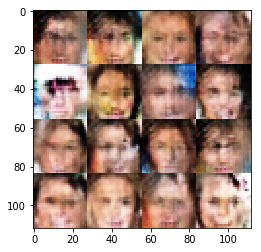

Epoch 2/10 Step 7000... Discriminator Loss: 0.4885... Generator Loss: -3.3423
Epoch 2/10 Step 7200... Discriminator Loss: 0.9089... Generator Loss: -9.8945


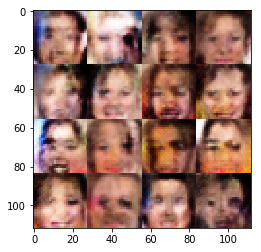

Epoch 2/10 Step 7400... Discriminator Loss: 0.6240... Generator Loss: 8.2675
Epoch 2/10 Step 7600... Discriminator Loss: 1.2275... Generator Loss: -5.4879


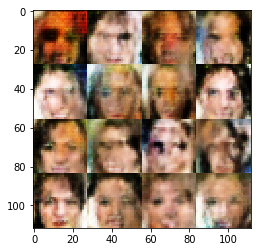

Epoch 2/10 Step 7800... Discriminator Loss: 0.3706... Generator Loss: -6.4250
Epoch 2/10 Step 8000... Discriminator Loss: 1.6571... Generator Loss: 12.3923


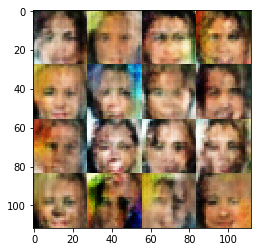

Epoch 2/10 Step 8200... Discriminator Loss: 5.5147... Generator Loss: 5.5438
Epoch 2/10 Step 8400... Discriminator Loss: -0.4881... Generator Loss: 8.1049


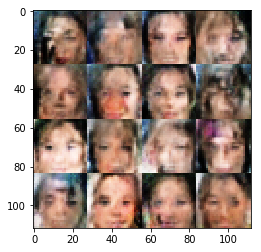

Epoch 2/10 Step 8600... Discriminator Loss: 1.4213... Generator Loss: -11.1874
Epoch 2/10 Step 8800... Discriminator Loss: 2.9857... Generator Loss: -2.0160


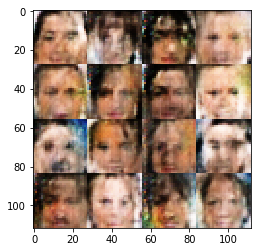

Epoch 2/10 Step 9000... Discriminator Loss: 0.8072... Generator Loss: 0.0245
Epoch 2/10 Step 9200... Discriminator Loss: 0.5076... Generator Loss: 6.6899


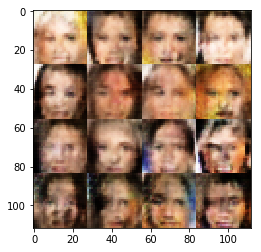

Epoch 2/10 Step 9400... Discriminator Loss: 2.0172... Generator Loss: -6.5901
Epoch 2/10 Step 9600... Discriminator Loss: 0.3217... Generator Loss: 1.8965


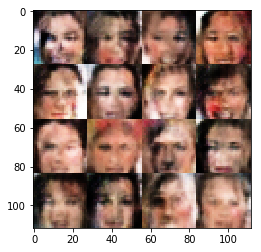

Epoch 2/10 Step 9800... Discriminator Loss: 0.5944... Generator Loss: -5.4178
Epoch 2/10 Step 10000... Discriminator Loss: 0.5958... Generator Loss: 8.6712


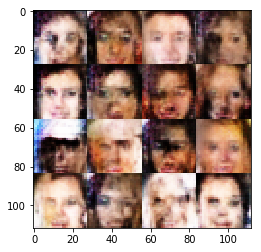

Epoch 2/10 Step 10200... Discriminator Loss: 0.6579... Generator Loss: 1.8337
Epoch 2/10 Step 10400... Discriminator Loss: 0.5606... Generator Loss: -0.3844


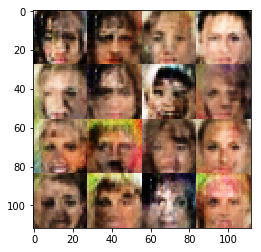

Epoch 2/10 Step 10600... Discriminator Loss: 0.4983... Generator Loss: 1.0237
Epoch 2/10 Step 10800... Discriminator Loss: -0.1522... Generator Loss: 0.8786


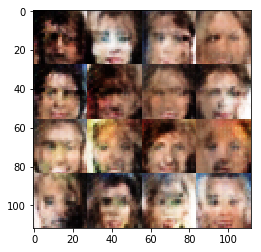

Epoch 2/10 Step 11000... Discriminator Loss: 0.5669... Generator Loss: 0.7183
Epoch 2/10 Step 11200... Discriminator Loss: 1.2175... Generator Loss: 0.6524


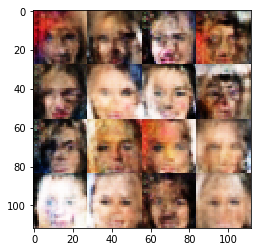

Epoch 2/10 Step 11400... Discriminator Loss: 0.9933... Generator Loss: 4.3836
Epoch 2/10 Step 11600... Discriminator Loss: 1.0409... Generator Loss: -2.1655


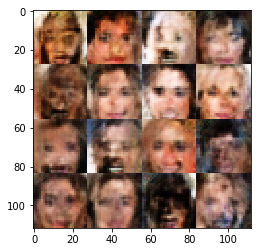

Epoch 2/10 Step 11800... Discriminator Loss: 0.8042... Generator Loss: -2.4876
Epoch 2/10 Step 12000... Discriminator Loss: 4.2064... Generator Loss: 0.4726


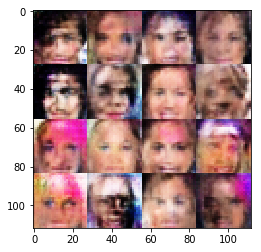

Epoch 2/10 Step 12200... Discriminator Loss: 3.0997... Generator Loss: -3.2705
Epoch 2/10 Step 12400... Discriminator Loss: 0.2774... Generator Loss: -9.0371


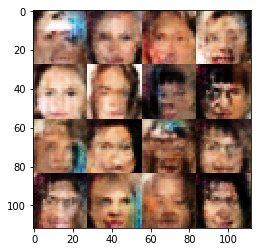

Epoch 2/10 Step 12600... Discriminator Loss: 0.2263... Generator Loss: -4.2442
Epoch 3/10 Step 12800... Discriminator Loss: 0.4569... Generator Loss: -4.0274


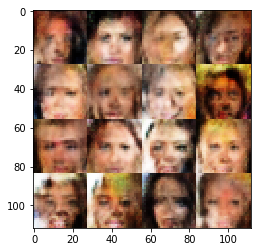

Epoch 3/10 Step 13000... Discriminator Loss: 0.8356... Generator Loss: 9.4666
Epoch 3/10 Step 13200... Discriminator Loss: 0.5972... Generator Loss: 1.8680


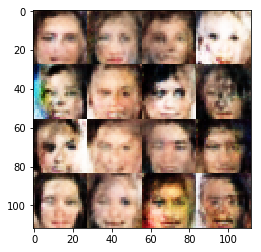

Epoch 3/10 Step 13400... Discriminator Loss: 0.0943... Generator Loss: -4.1367
Epoch 3/10 Step 13600... Discriminator Loss: 0.3296... Generator Loss: -0.0744


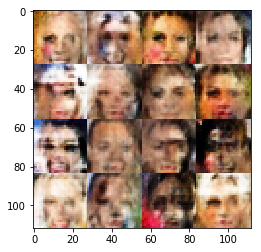

Epoch 3/10 Step 13800... Discriminator Loss: 0.7224... Generator Loss: -2.7899
Epoch 3/10 Step 14000... Discriminator Loss: 0.8824... Generator Loss: 1.3516


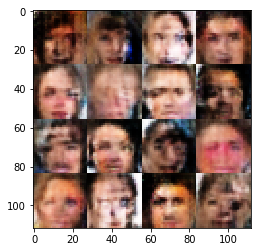

Epoch 3/10 Step 14200... Discriminator Loss: 0.0905... Generator Loss: 2.4612
Epoch 3/10 Step 14400... Discriminator Loss: 1.3936... Generator Loss: 3.9578


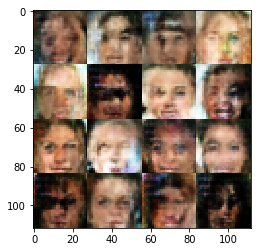

Epoch 3/10 Step 14600... Discriminator Loss: 1.0466... Generator Loss: 4.0750
Epoch 3/10 Step 14800... Discriminator Loss: 2.2078... Generator Loss: -5.0832


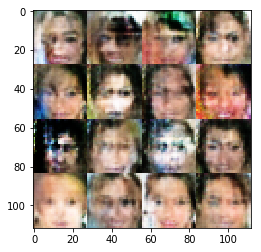

Epoch 3/10 Step 15000... Discriminator Loss: 1.0098... Generator Loss: -11.4275
Epoch 3/10 Step 15200... Discriminator Loss: 0.0726... Generator Loss: -0.4924


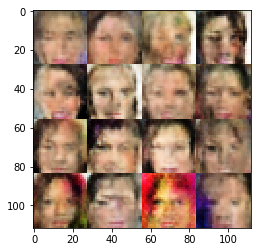

Epoch 3/10 Step 15400... Discriminator Loss: 0.3153... Generator Loss: -10.5305
Epoch 3/10 Step 15600... Discriminator Loss: -0.4522... Generator Loss: 1.8452


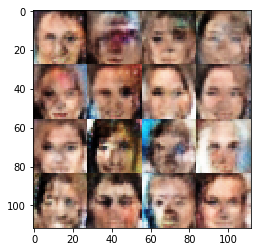

Epoch 3/10 Step 15800... Discriminator Loss: 0.3037... Generator Loss: -7.0497
Epoch 3/10 Step 16000... Discriminator Loss: 1.3457... Generator Loss: -6.3785


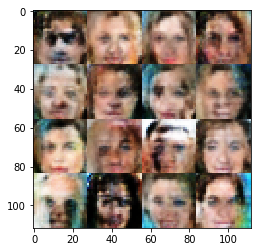

Epoch 3/10 Step 16200... Discriminator Loss: 1.4521... Generator Loss: 0.3552
Epoch 3/10 Step 16400... Discriminator Loss: 1.2702... Generator Loss: -2.1186


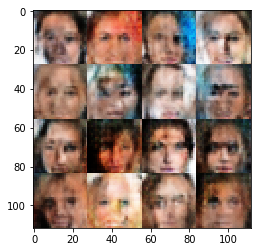

Epoch 3/10 Step 16600... Discriminator Loss: 0.7382... Generator Loss: -5.1792
Epoch 3/10 Step 16800... Discriminator Loss: 1.2341... Generator Loss: -2.4638


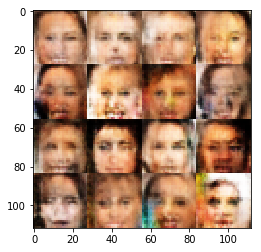

Epoch 3/10 Step 17000... Discriminator Loss: 0.5485... Generator Loss: -2.1636
Epoch 3/10 Step 17200... Discriminator Loss: 4.4289... Generator Loss: -1.1204


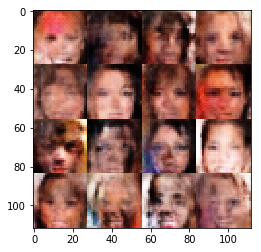

Epoch 3/10 Step 17400... Discriminator Loss: 0.1573... Generator Loss: -4.4068
Epoch 3/10 Step 17600... Discriminator Loss: 0.4037... Generator Loss: -1.7263


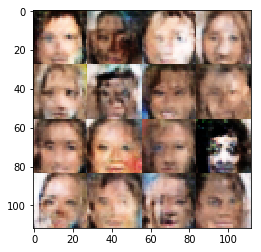

Epoch 3/10 Step 17800... Discriminator Loss: 0.9160... Generator Loss: -3.7559
Epoch 3/10 Step 18000... Discriminator Loss: 0.1799... Generator Loss: 3.6249


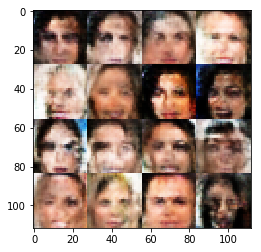

Epoch 3/10 Step 18200... Discriminator Loss: 1.0327... Generator Loss: 0.8823
Epoch 3/10 Step 18400... Discriminator Loss: 0.6387... Generator Loss: 1.2216


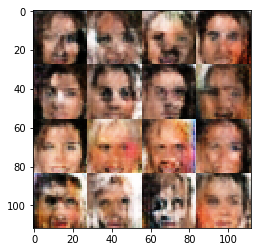

Epoch 3/10 Step 18600... Discriminator Loss: 0.2957... Generator Loss: -7.1684
Epoch 3/10 Step 18800... Discriminator Loss: 0.4232... Generator Loss: 3.1465


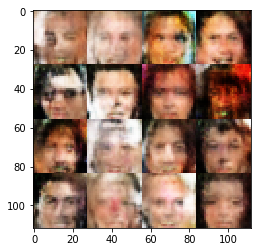

Epoch 4/10 Step 19000... Discriminator Loss: 1.8269... Generator Loss: 4.4964
Epoch 4/10 Step 19200... Discriminator Loss: 0.4831... Generator Loss: 5.0793


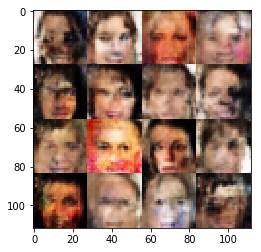

Epoch 4/10 Step 19400... Discriminator Loss: 0.2288... Generator Loss: 4.5207
Epoch 4/10 Step 19600... Discriminator Loss: 0.8521... Generator Loss: -6.0776


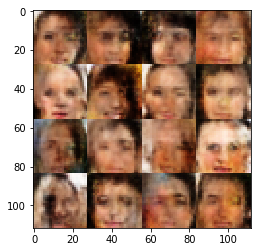

Epoch 4/10 Step 19800... Discriminator Loss: 0.9192... Generator Loss: -4.7773
Epoch 4/10 Step 20000... Discriminator Loss: 0.1804... Generator Loss: -0.2032


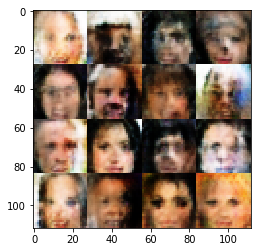

Epoch 4/10 Step 20200... Discriminator Loss: 0.1036... Generator Loss: -2.7769
Epoch 4/10 Step 20400... Discriminator Loss: 0.6037... Generator Loss: 4.0987


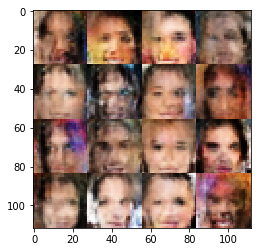

Epoch 4/10 Step 20600... Discriminator Loss: 0.5047... Generator Loss: 5.1039
Epoch 4/10 Step 20800... Discriminator Loss: 0.0327... Generator Loss: 0.6629


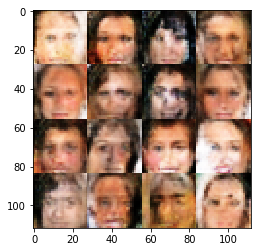

Epoch 4/10 Step 21000... Discriminator Loss: -0.0822... Generator Loss: -1.1854
Epoch 4/10 Step 21200... Discriminator Loss: 0.5653... Generator Loss: 0.1064


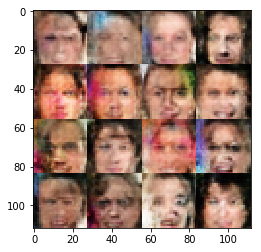

Epoch 4/10 Step 21400... Discriminator Loss: 0.1798... Generator Loss: 4.1609
Epoch 4/10 Step 21600... Discriminator Loss: 0.8410... Generator Loss: 1.4912


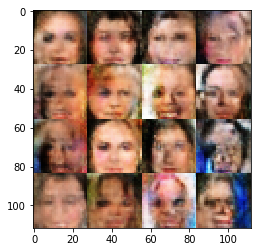

Epoch 4/10 Step 21800... Discriminator Loss: -0.4016... Generator Loss: -1.2291
Epoch 4/10 Step 22000... Discriminator Loss: 0.4408... Generator Loss: -6.7196


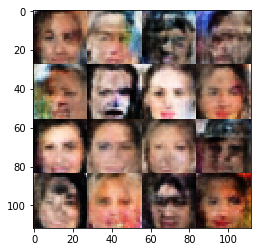

Epoch 4/10 Step 22200... Discriminator Loss: -0.0087... Generator Loss: 2.6374
Epoch 4/10 Step 22400... Discriminator Loss: 0.7328... Generator Loss: -7.7787


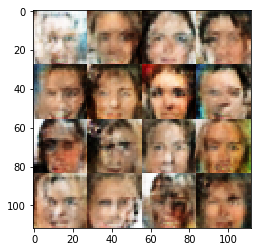

Epoch 4/10 Step 22600... Discriminator Loss: 0.1254... Generator Loss: -4.7204
Epoch 4/10 Step 22800... Discriminator Loss: 0.3357... Generator Loss: -11.0266


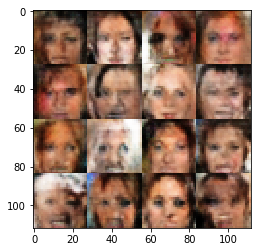

Epoch 4/10 Step 23000... Discriminator Loss: 0.0139... Generator Loss: -1.8616
Epoch 4/10 Step 23200... Discriminator Loss: 0.4282... Generator Loss: -1.7355


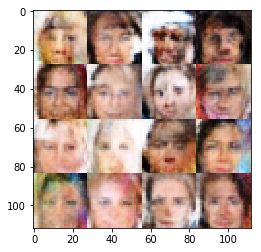

Epoch 4/10 Step 23400... Discriminator Loss: 1.2344... Generator Loss: -1.6530
Epoch 4/10 Step 23600... Discriminator Loss: 0.2978... Generator Loss: -10.7466


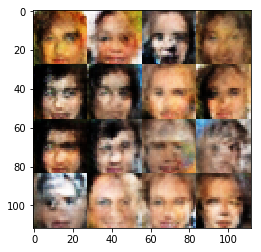

Epoch 4/10 Step 23800... Discriminator Loss: 0.7566... Generator Loss: -6.8944
Epoch 4/10 Step 24000... Discriminator Loss: 1.2420... Generator Loss: -6.1500


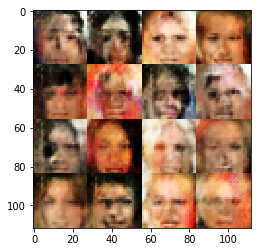

Epoch 4/10 Step 24200... Discriminator Loss: 0.7690... Generator Loss: 1.0925
Epoch 4/10 Step 24400... Discriminator Loss: 1.3954... Generator Loss: -2.2548


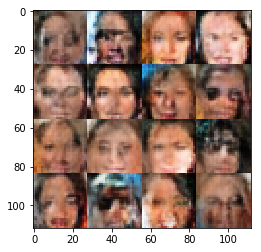

Epoch 4/10 Step 24600... Discriminator Loss: 0.3674... Generator Loss: -2.1450
Epoch 4/10 Step 24800... Discriminator Loss: 0.6605... Generator Loss: -2.9412


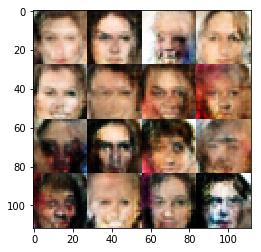

Epoch 4/10 Step 25000... Discriminator Loss: 0.4845... Generator Loss: -1.5424
Epoch 4/10 Step 25200... Discriminator Loss: 0.3308... Generator Loss: 1.6322


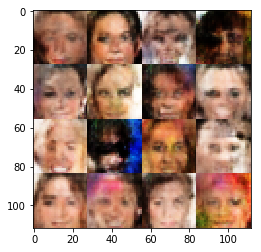

Epoch 5/10 Step 25400... Discriminator Loss: 0.8018... Generator Loss: 3.2972
Epoch 5/10 Step 25600... Discriminator Loss: 0.8831... Generator Loss: 5.1877


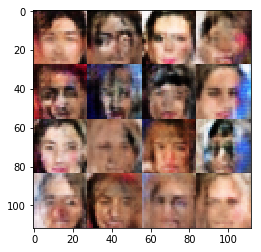

Epoch 5/10 Step 25800... Discriminator Loss: 0.1756... Generator Loss: -0.0198
Epoch 5/10 Step 26000... Discriminator Loss: 0.4516... Generator Loss: 8.3564


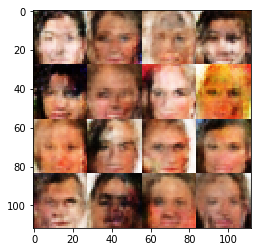

Epoch 5/10 Step 26200... Discriminator Loss: 0.8688... Generator Loss: -1.2875
Epoch 5/10 Step 26400... Discriminator Loss: -1.3234... Generator Loss: 0.9094


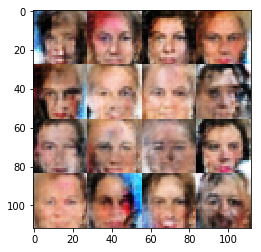

Epoch 5/10 Step 26600... Discriminator Loss: -0.0120... Generator Loss: 4.3533
Epoch 5/10 Step 26800... Discriminator Loss: 0.3975... Generator Loss: -3.0867


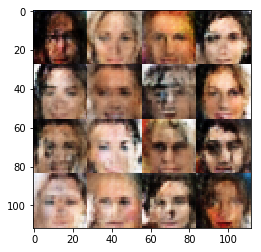

Epoch 5/10 Step 27000... Discriminator Loss: 0.8314... Generator Loss: -1.9500
Epoch 5/10 Step 27200... Discriminator Loss: 0.8763... Generator Loss: -2.0491


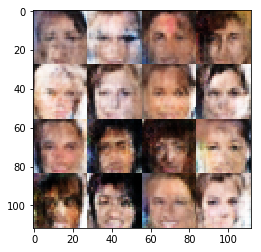

Epoch 5/10 Step 27400... Discriminator Loss: 1.0325... Generator Loss: -0.3668
Epoch 5/10 Step 27600... Discriminator Loss: 0.4139... Generator Loss: -6.8045


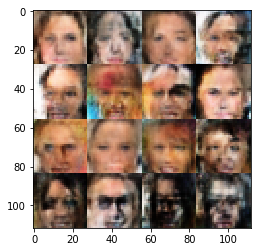

Epoch 5/10 Step 27800... Discriminator Loss: 0.0945... Generator Loss: 0.5647
Epoch 5/10 Step 28000... Discriminator Loss: 0.4022... Generator Loss: -6.3348


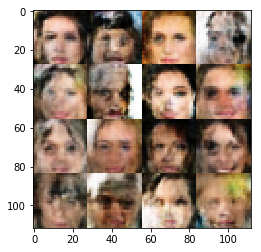

Epoch 5/10 Step 28200... Discriminator Loss: 0.0930... Generator Loss: -4.1001
Epoch 5/10 Step 28400... Discriminator Loss: 0.7646... Generator Loss: -4.4754


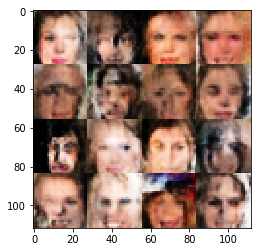

Epoch 5/10 Step 28600... Discriminator Loss: 0.2449... Generator Loss: -5.7314
Epoch 5/10 Step 28800... Discriminator Loss: -0.3712... Generator Loss: -4.8587


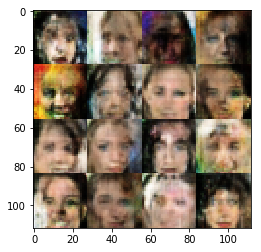

Epoch 5/10 Step 29000... Discriminator Loss: 0.2335... Generator Loss: -0.4141
Epoch 5/10 Step 29200... Discriminator Loss: -0.0732... Generator Loss: -8.0057


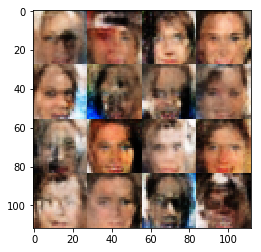

Epoch 5/10 Step 29400... Discriminator Loss: 0.2655... Generator Loss: -1.7996
Epoch 5/10 Step 29600... Discriminator Loss: 0.8759... Generator Loss: 0.9427


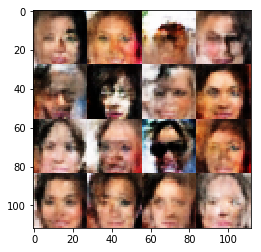

Epoch 5/10 Step 29800... Discriminator Loss: 0.4570... Generator Loss: -5.3541
Epoch 5/10 Step 30000... Discriminator Loss: 0.2435... Generator Loss: -8.5344


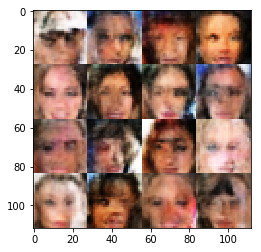

Epoch 5/10 Step 30200... Discriminator Loss: 0.8233... Generator Loss: 0.5048
Epoch 5/10 Step 30400... Discriminator Loss: 0.5398... Generator Loss: 0.3477


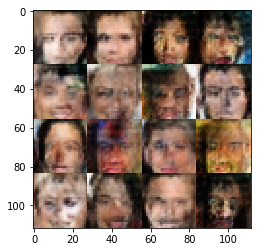

Epoch 5/10 Step 30600... Discriminator Loss: 1.1110... Generator Loss: -2.2464
Epoch 5/10 Step 30800... Discriminator Loss: 0.2473... Generator Loss: 0.4909


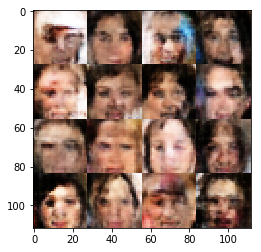

Epoch 5/10 Step 31000... Discriminator Loss: 0.7600... Generator Loss: -6.3756
Epoch 5/10 Step 31200... Discriminator Loss: 0.4807... Generator Loss: 5.3814


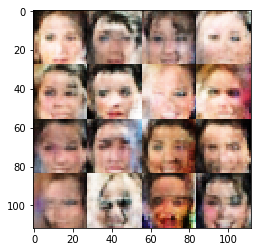

Epoch 5/10 Step 31400... Discriminator Loss: 0.2473... Generator Loss: -1.0267
Epoch 5/10 Step 31600... Discriminator Loss: 2.6413... Generator Loss: -4.1568


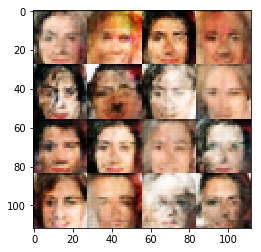

Epoch 6/10 Step 31800... Discriminator Loss: 0.2378... Generator Loss: -5.1751
Epoch 6/10 Step 32000... Discriminator Loss: 0.7995... Generator Loss: 2.8199


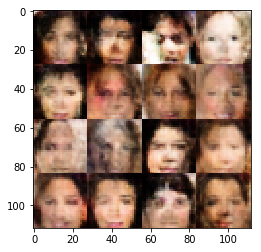

Epoch 6/10 Step 32200... Discriminator Loss: 0.5075... Generator Loss: -2.6998
Epoch 6/10 Step 32400... Discriminator Loss: 0.5481... Generator Loss: 0.8480


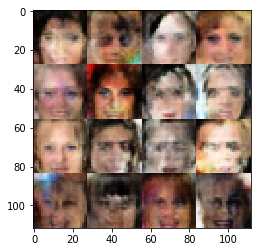

Epoch 6/10 Step 32600... Discriminator Loss: 0.0592... Generator Loss: 0.2527
Epoch 6/10 Step 32800... Discriminator Loss: -0.1129... Generator Loss: -1.7483


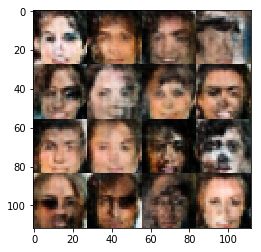

Epoch 6/10 Step 33000... Discriminator Loss: 0.9020... Generator Loss: -1.4295
Epoch 6/10 Step 33200... Discriminator Loss: 0.4591... Generator Loss: -2.4384


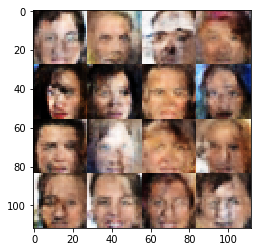

Epoch 6/10 Step 33400... Discriminator Loss: 0.1675... Generator Loss: -6.4189
Epoch 6/10 Step 33600... Discriminator Loss: -0.4170... Generator Loss: 1.0870


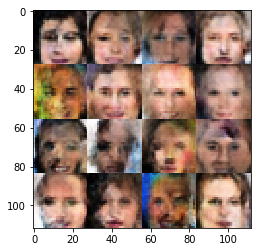

Epoch 6/10 Step 33800... Discriminator Loss: 0.4129... Generator Loss: -5.1929
Epoch 6/10 Step 34000... Discriminator Loss: -0.1133... Generator Loss: -2.6331


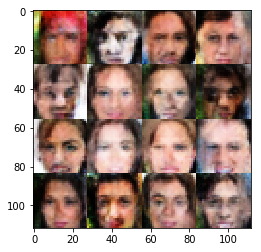

Epoch 6/10 Step 34200... Discriminator Loss: 0.2137... Generator Loss: 1.4359
Epoch 6/10 Step 34400... Discriminator Loss: 0.8213... Generator Loss: -5.5079


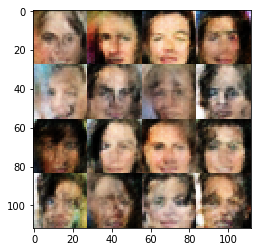

Epoch 6/10 Step 34600... Discriminator Loss: 0.0117... Generator Loss: -6.4952
Epoch 6/10 Step 34800... Discriminator Loss: -0.2477... Generator Loss: 4.4771


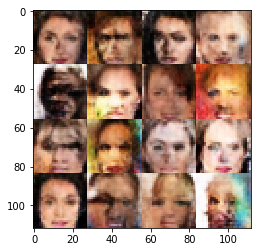

Epoch 6/10 Step 35000... Discriminator Loss: 0.0872... Generator Loss: -0.3277
Epoch 6/10 Step 35200... Discriminator Loss: 0.0087... Generator Loss: -8.1558


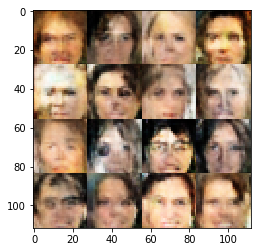

Epoch 6/10 Step 35400... Discriminator Loss: 0.2537... Generator Loss: -10.4930
Epoch 6/10 Step 35600... Discriminator Loss: 1.3479... Generator Loss: -5.4407


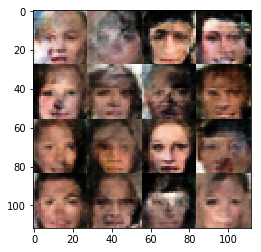

Epoch 6/10 Step 35800... Discriminator Loss: -0.0490... Generator Loss: -7.1668
Epoch 6/10 Step 36000... Discriminator Loss: -0.5695... Generator Loss: -1.9460


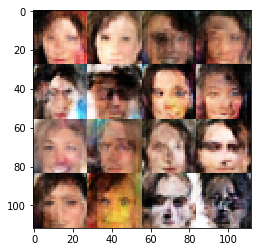

Epoch 6/10 Step 36200... Discriminator Loss: 0.6199... Generator Loss: -2.9561
Epoch 6/10 Step 36400... Discriminator Loss: 1.1656... Generator Loss: -10.3857


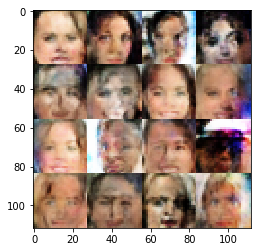

Epoch 6/10 Step 36600... Discriminator Loss: -0.6775... Generator Loss: -1.8406
Epoch 6/10 Step 36800... Discriminator Loss: -0.9227... Generator Loss: -8.3480


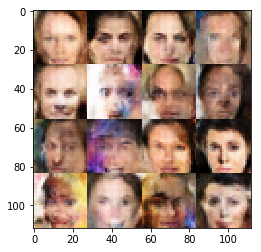

Epoch 6/10 Step 37000... Discriminator Loss: 0.1153... Generator Loss: -13.7426
Epoch 6/10 Step 37200... Discriminator Loss: -0.0093... Generator Loss: -8.1271


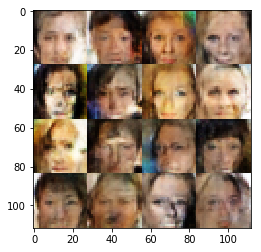

Epoch 6/10 Step 37400... Discriminator Loss: -3.5505... Generator Loss: -5.9418
Epoch 6/10 Step 37600... Discriminator Loss: -0.0164... Generator Loss: -7.9261


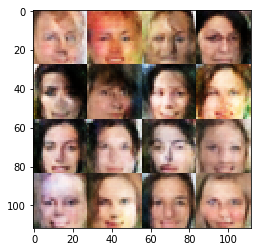

Epoch 6/10 Step 37800... Discriminator Loss: -1.7440... Generator Loss: -14.2634
Epoch 7/10 Step 38000... Discriminator Loss: -1.8230... Generator Loss: -9.8060


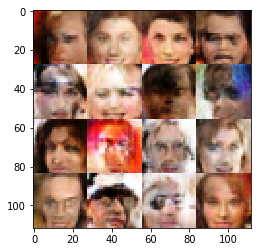

Epoch 7/10 Step 38200... Discriminator Loss: -0.4069... Generator Loss: -12.4253
Epoch 7/10 Step 38400... Discriminator Loss: -1.1256... Generator Loss: -20.4943


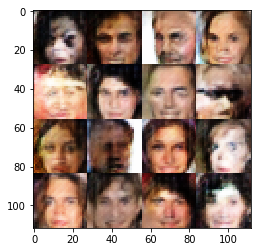

Epoch 7/10 Step 38600... Discriminator Loss: 0.1269... Generator Loss: -14.5298
Epoch 7/10 Step 38800... Discriminator Loss: -2.6580... Generator Loss: -8.0007


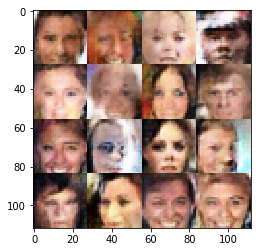

Epoch 7/10 Step 39000... Discriminator Loss: -1.6792... Generator Loss: -21.2281
Epoch 7/10 Step 39200... Discriminator Loss: -1.9788... Generator Loss: -13.5395


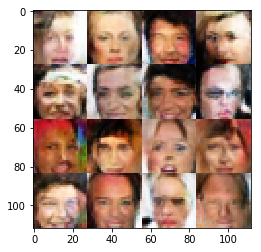

Epoch 7/10 Step 39400... Discriminator Loss: -1.2932... Generator Loss: -9.5317
Epoch 7/10 Step 39600... Discriminator Loss: -1.3268... Generator Loss: -11.0446


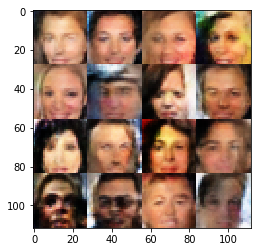

Epoch 7/10 Step 39800... Discriminator Loss: -1.5177... Generator Loss: -14.1813
Epoch 7/10 Step 40000... Discriminator Loss: -3.9580... Generator Loss: -9.8444


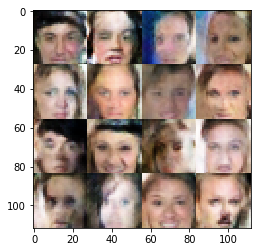

Epoch 7/10 Step 40200... Discriminator Loss: -1.2695... Generator Loss: -13.8286
Epoch 7/10 Step 40400... Discriminator Loss: 0.5536... Generator Loss: -14.8001


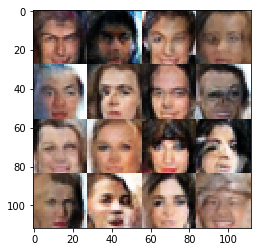

Epoch 7/10 Step 40600... Discriminator Loss: -3.8075... Generator Loss: -9.1458
Epoch 7/10 Step 40800... Discriminator Loss: -1.1097... Generator Loss: -9.0604


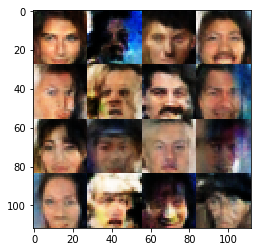

Epoch 7/10 Step 41000... Discriminator Loss: -1.2248... Generator Loss: -7.4628
Epoch 7/10 Step 41200... Discriminator Loss: -1.9505... Generator Loss: -12.3912


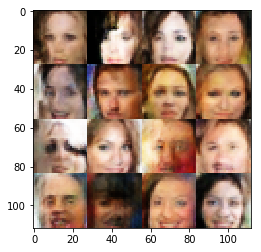

Epoch 7/10 Step 41400... Discriminator Loss: -1.4057... Generator Loss: -10.3123
Epoch 7/10 Step 41600... Discriminator Loss: -4.4604... Generator Loss: -4.5866


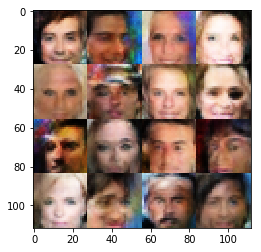

Epoch 7/10 Step 41800... Discriminator Loss: -1.4393... Generator Loss: -16.8339
Epoch 7/10 Step 42000... Discriminator Loss: -2.6610... Generator Loss: -10.7510


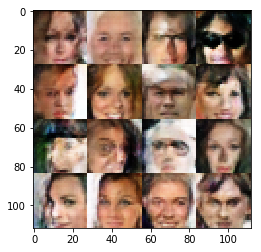

Epoch 7/10 Step 42200... Discriminator Loss: -1.3277... Generator Loss: -6.8567
Epoch 7/10 Step 42400... Discriminator Loss: -1.0269... Generator Loss: -7.0912


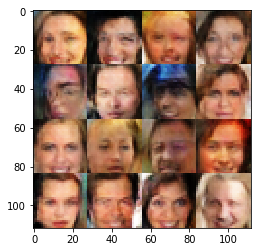

Epoch 7/10 Step 42600... Discriminator Loss: -1.3169... Generator Loss: -8.8439
Epoch 7/10 Step 42800... Discriminator Loss: -2.1070... Generator Loss: -8.8680


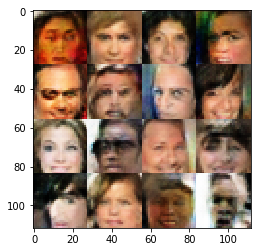

Epoch 7/10 Step 43000... Discriminator Loss: -3.0865... Generator Loss: -9.1610
Epoch 7/10 Step 43200... Discriminator Loss: -0.9864... Generator Loss: -5.6181


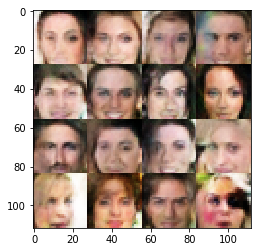

Epoch 7/10 Step 43400... Discriminator Loss: -0.1654... Generator Loss: -17.7282
Epoch 7/10 Step 43600... Discriminator Loss: -1.5629... Generator Loss: -12.1221


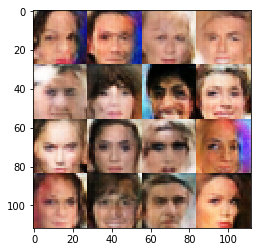

Epoch 7/10 Step 43800... Discriminator Loss: -2.0728... Generator Loss: -10.4828
Epoch 7/10 Step 44000... Discriminator Loss: 0.4553... Generator Loss: -9.8541


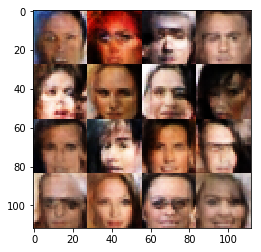

Epoch 7/10 Step 44200... Discriminator Loss: -0.7470... Generator Loss: -8.2781
Epoch 8/10 Step 44400... Discriminator Loss: -0.1380... Generator Loss: -15.6635


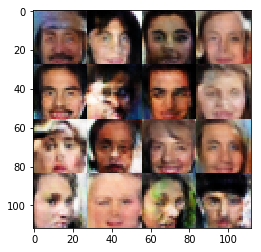

Epoch 8/10 Step 44600... Discriminator Loss: -2.3435... Generator Loss: -12.8204
Epoch 8/10 Step 44800... Discriminator Loss: -0.4789... Generator Loss: -10.2208


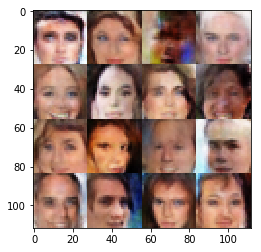

Epoch 8/10 Step 45000... Discriminator Loss: -0.1823... Generator Loss: -7.6431
Epoch 8/10 Step 45200... Discriminator Loss: 1.8943... Generator Loss: -14.3789


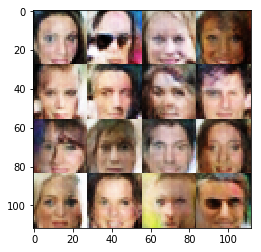

Epoch 8/10 Step 45400... Discriminator Loss: -1.4441... Generator Loss: -8.3290
Epoch 8/10 Step 45600... Discriminator Loss: -3.1703... Generator Loss: -9.5511


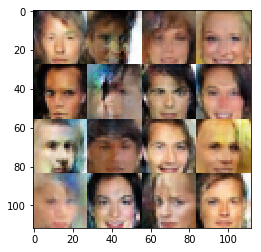

Epoch 8/10 Step 45800... Discriminator Loss: -0.6888... Generator Loss: -13.5288
Epoch 8/10 Step 46000... Discriminator Loss: -0.9488... Generator Loss: -9.4543


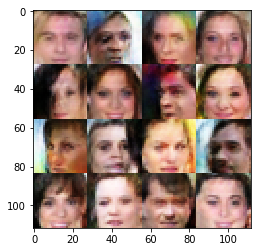

Epoch 8/10 Step 46200... Discriminator Loss: -2.9882... Generator Loss: -4.2216
Epoch 8/10 Step 46400... Discriminator Loss: -1.4746... Generator Loss: -5.1841


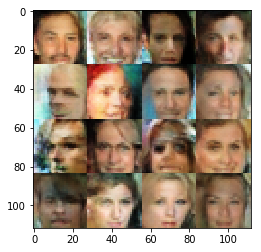

Epoch 8/10 Step 46600... Discriminator Loss: -2.0498... Generator Loss: -10.5041
Epoch 8/10 Step 46800... Discriminator Loss: -0.6565... Generator Loss: -9.5955


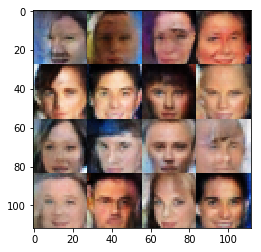

Epoch 8/10 Step 47000... Discriminator Loss: 1.9477... Generator Loss: -16.0672
Epoch 8/10 Step 47200... Discriminator Loss: -0.2480... Generator Loss: -13.8444


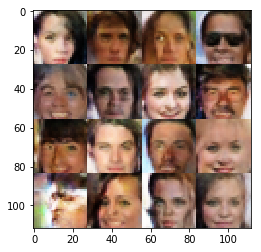

Epoch 8/10 Step 47400... Discriminator Loss: -1.3367... Generator Loss: -12.8663
Epoch 8/10 Step 47600... Discriminator Loss: -1.5856... Generator Loss: -7.1116


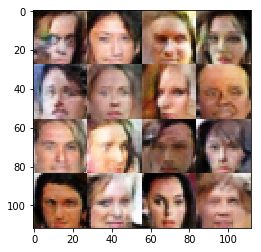

Epoch 8/10 Step 47800... Discriminator Loss: -0.1848... Generator Loss: -6.4762
Epoch 8/10 Step 48000... Discriminator Loss: -0.3577... Generator Loss: -7.4734


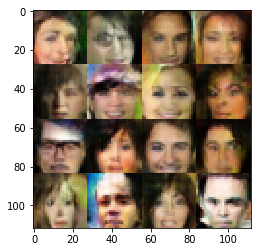

Epoch 8/10 Step 48200... Discriminator Loss: -1.5100... Generator Loss: -18.4210
Epoch 8/10 Step 48400... Discriminator Loss: -1.0344... Generator Loss: -8.2143


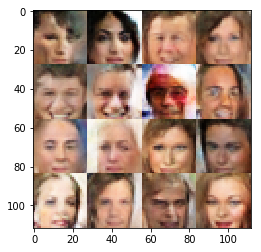

Epoch 8/10 Step 48600... Discriminator Loss: -1.0944... Generator Loss: -6.7777
Epoch 8/10 Step 48800... Discriminator Loss: 0.7463... Generator Loss: -4.8211


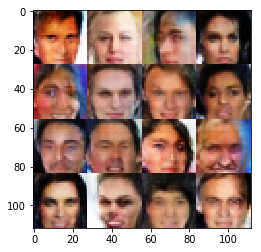

Epoch 8/10 Step 49000... Discriminator Loss: -1.7427... Generator Loss: -4.9766
Epoch 8/10 Step 49200... Discriminator Loss: 1.2146... Generator Loss: -10.8162


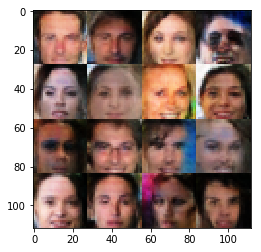

Epoch 8/10 Step 49400... Discriminator Loss: -2.1328... Generator Loss: -3.9877
Epoch 8/10 Step 49600... Discriminator Loss: -0.7700... Generator Loss: -4.9805


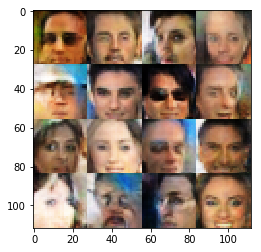

Epoch 8/10 Step 49800... Discriminator Loss: -1.2581... Generator Loss: -3.2599
Epoch 8/10 Step 50000... Discriminator Loss: -0.2907... Generator Loss: -7.3965


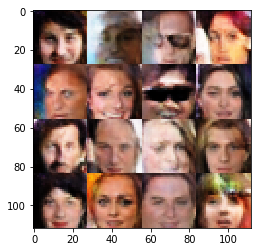

Epoch 8/10 Step 50200... Discriminator Loss: -0.6262... Generator Loss: -8.3139
Epoch 8/10 Step 50400... Discriminator Loss: -2.2427... Generator Loss: -8.6910


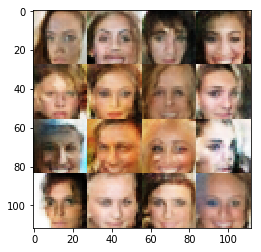

Epoch 8/10 Step 50600... Discriminator Loss: 0.3125... Generator Loss: -10.6889
Epoch 9/10 Step 50800... Discriminator Loss: -1.2247... Generator Loss: -8.6646


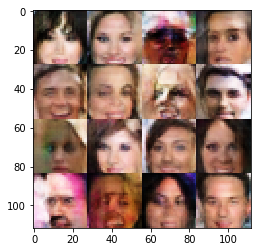

Epoch 9/10 Step 51000... Discriminator Loss: 0.3990... Generator Loss: -11.0880
Epoch 9/10 Step 51200... Discriminator Loss: -1.5426... Generator Loss: -6.1880


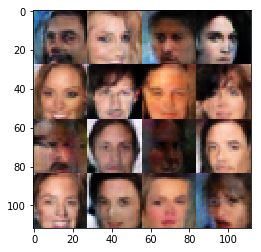

Epoch 9/10 Step 51400... Discriminator Loss: -0.3644... Generator Loss: -6.2408
Epoch 9/10 Step 51600... Discriminator Loss: 0.7796... Generator Loss: -11.6875


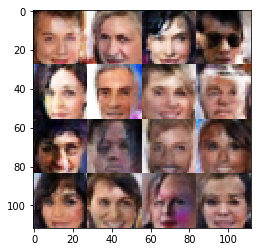

Epoch 9/10 Step 51800... Discriminator Loss: -1.7979... Generator Loss: -7.5659
Epoch 9/10 Step 52000... Discriminator Loss: -0.2625... Generator Loss: -5.5823


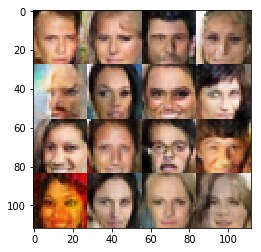

Epoch 9/10 Step 52200... Discriminator Loss: 0.4527... Generator Loss: -12.0072
Epoch 9/10 Step 52400... Discriminator Loss: -0.9674... Generator Loss: -5.4154


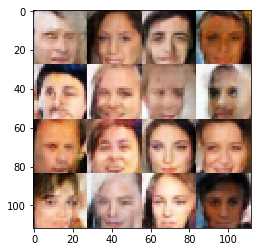

Epoch 9/10 Step 52600... Discriminator Loss: -2.2033... Generator Loss: -6.5909
Epoch 9/10 Step 52800... Discriminator Loss: -0.4013... Generator Loss: -5.1983


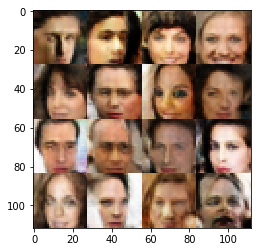

Epoch 9/10 Step 53000... Discriminator Loss: -0.2975... Generator Loss: -7.4622
Epoch 9/10 Step 53200... Discriminator Loss: 0.4463... Generator Loss: -7.2622


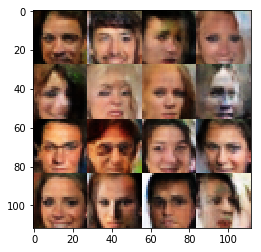

Epoch 9/10 Step 53400... Discriminator Loss: -1.5096... Generator Loss: -9.4658
Epoch 9/10 Step 53600... Discriminator Loss: -0.6540... Generator Loss: -11.6796


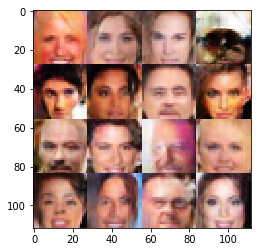

Epoch 9/10 Step 53800... Discriminator Loss: -1.2840... Generator Loss: -11.5132
Epoch 9/10 Step 54000... Discriminator Loss: 0.4308... Generator Loss: -5.7492


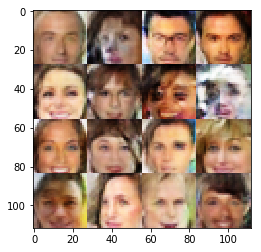

Epoch 9/10 Step 54200... Discriminator Loss: -2.1224... Generator Loss: -6.3060
Epoch 9/10 Step 54400... Discriminator Loss: 3.4166... Generator Loss: -15.7843


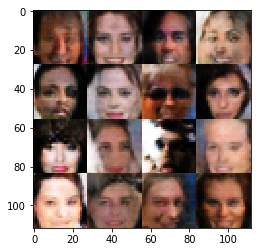

Epoch 9/10 Step 54600... Discriminator Loss: -1.0156... Generator Loss: -6.0999
Epoch 9/10 Step 54800... Discriminator Loss: -1.1746... Generator Loss: -6.9916


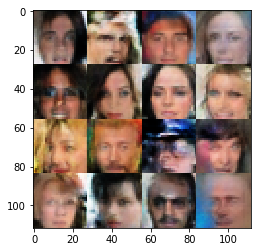

Epoch 9/10 Step 55000... Discriminator Loss: 0.6733... Generator Loss: -7.0415
Epoch 9/10 Step 55200... Discriminator Loss: -1.1509... Generator Loss: -8.0285


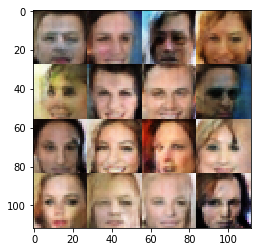

Epoch 9/10 Step 55400... Discriminator Loss: -0.2007... Generator Loss: -7.4396
Epoch 9/10 Step 55600... Discriminator Loss: -0.7324... Generator Loss: -0.8915


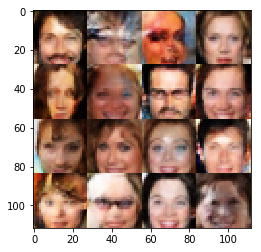

Epoch 9/10 Step 55800... Discriminator Loss: -1.8854... Generator Loss: -12.5247
Epoch 9/10 Step 56000... Discriminator Loss: -1.3592... Generator Loss: -9.1313


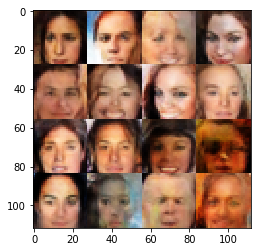

Epoch 9/10 Step 56200... Discriminator Loss: -0.8102... Generator Loss: -6.6077
Epoch 9/10 Step 56400... Discriminator Loss: -1.5614... Generator Loss: -6.7810


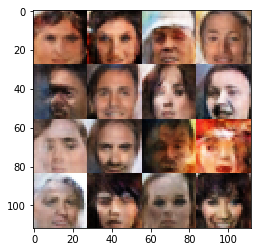

Epoch 9/10 Step 56600... Discriminator Loss: -0.9714... Generator Loss: -2.3574
Epoch 9/10 Step 56800... Discriminator Loss: 1.9356... Generator Loss: -6.5640


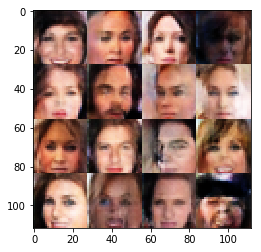

Epoch 10/10 Step 57000... Discriminator Loss: -1.1097... Generator Loss: -8.3921
Epoch 10/10 Step 57200... Discriminator Loss: -1.0052... Generator Loss: -3.0449


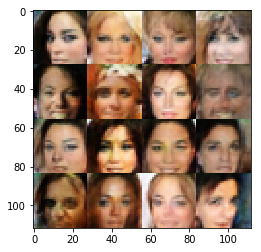

Epoch 10/10 Step 57400... Discriminator Loss: 0.8558... Generator Loss: -16.3686
Epoch 10/10 Step 57600... Discriminator Loss: -0.3797... Generator Loss: -5.4623


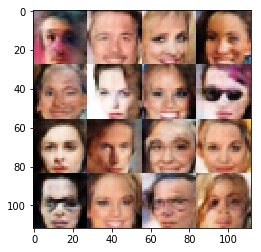

Epoch 10/10 Step 57800... Discriminator Loss: -0.3909... Generator Loss: -7.4093
Epoch 10/10 Step 58000... Discriminator Loss: -0.7814... Generator Loss: -1.1179


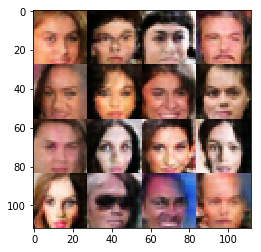

Epoch 10/10 Step 58200... Discriminator Loss: 0.0713... Generator Loss: -4.0539
Epoch 10/10 Step 58400... Discriminator Loss: -0.5236... Generator Loss: -3.6278


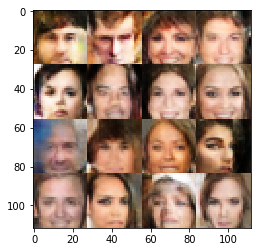

Epoch 10/10 Step 58600... Discriminator Loss: -0.6026... Generator Loss: -2.7089
Epoch 10/10 Step 58800... Discriminator Loss: -0.0974... Generator Loss: -7.9042


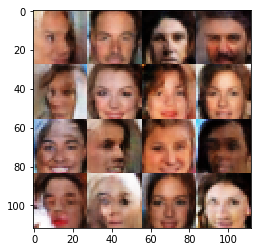

Epoch 10/10 Step 59000... Discriminator Loss: -2.6403... Generator Loss: -4.3816
Epoch 10/10 Step 59200... Discriminator Loss: -0.6047... Generator Loss: -2.6088


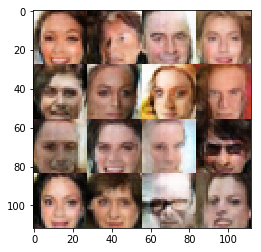

Epoch 10/10 Step 59400... Discriminator Loss: -2.2231... Generator Loss: -2.8159
Epoch 10/10 Step 59600... Discriminator Loss: 0.0209... Generator Loss: -4.2744


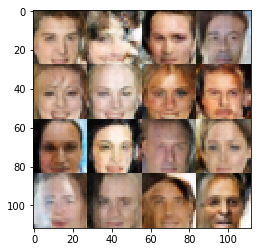

Epoch 10/10 Step 59800... Discriminator Loss: -0.3332... Generator Loss: -8.6325
Epoch 10/10 Step 60000... Discriminator Loss: 1.2282... Generator Loss: -11.0687


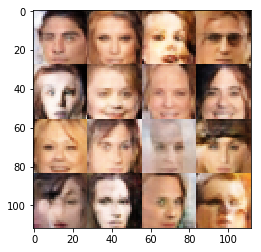

Epoch 10/10 Step 60200... Discriminator Loss: 0.0133... Generator Loss: -1.4876
Epoch 10/10 Step 60400... Discriminator Loss: -0.4516... Generator Loss: -9.3166


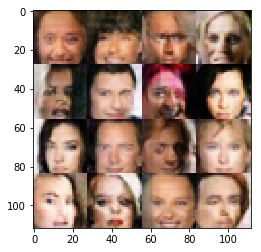

Epoch 10/10 Step 60600... Discriminator Loss: -0.1084... Generator Loss: -0.3088
Epoch 10/10 Step 60800... Discriminator Loss: 0.6798... Generator Loss: -8.1187


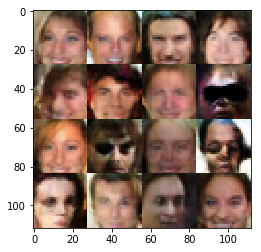

Epoch 10/10 Step 61000... Discriminator Loss: -1.2842... Generator Loss: -6.3141
Epoch 10/10 Step 61200... Discriminator Loss: -1.1507... Generator Loss: -6.6260


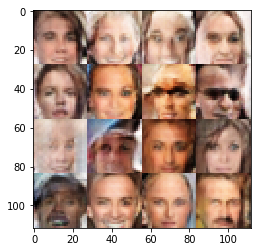

Epoch 10/10 Step 61400... Discriminator Loss: -1.7174... Generator Loss: -3.3642
Epoch 10/10 Step 61600... Discriminator Loss: 0.2522... Generator Loss: -1.5342


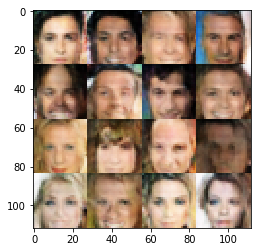

Epoch 10/10 Step 61800... Discriminator Loss: -0.4107... Generator Loss: -3.2432
Epoch 10/10 Step 62000... Discriminator Loss: -0.4879... Generator Loss: -1.9380


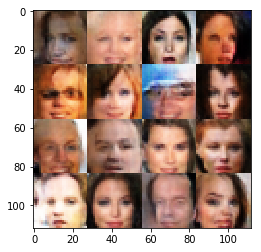

Epoch 10/10 Step 62200... Discriminator Loss: -1.3690... Generator Loss: -1.2007
Epoch 10/10 Step 62400... Discriminator Loss: 0.0482... Generator Loss: -10.1313


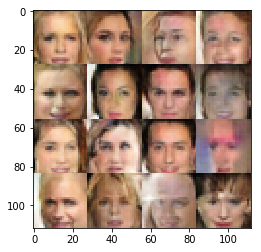

Epoch 10/10 Step 62600... Discriminator Loss: -0.8710... Generator Loss: -5.2411
Epoch 10/10 Step 62800... Discriminator Loss: -0.6925... Generator Loss: -4.4450


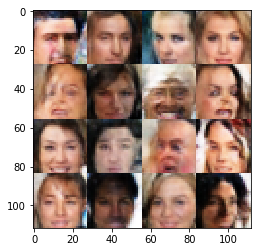

Epoch 10/10 Step 63000... Discriminator Loss: 0.1846... Generator Loss: -8.7463
Epoch 10/10 Step 63200... Discriminator Loss: 0.5392... Generator Loss: -2.6555


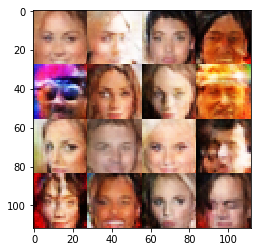

In [22]:
batch_size = 32
z_dim = 100
learning_rate = 0.003
LAMBDA = 12 # 梯度惩罚项lambda 
epochs = 10

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(celeba_datadir, '*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

In [ ]:
batch_size =32
z_dim = 100
learning_rate = 0.003
LAMBDA = 12 # 梯度惩罚项lambda 
epochs = 1

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(mnist_datadir, '*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate,mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)